
# By - Yash Khandelwal


In [ ]:
!unzip /content/drive/MyDrive/Shiv_Nadar_DAC.zip

Archive:  /content/drive/MyDrive/Shiv_Nadar_DAC.zip
  inflating: submission.csv          
  inflating: test.csv                
  inflating: train.csv               


**Importing the libraries**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor, plot_importance
from matplotlib import pyplot
from sklearn.feature_selection import mutual_info_regression, SelectFromModel 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV,Lasso,Ridge,RidgeCV,ElasticNet

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
sub = pd.read_csv('/content/submission.csv')

In [ ]:
train.shape

(87864, 9)

In [ ]:
test.shape

(37656, 8)

In [ ]:
train.head(5)

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,3437.350375
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,3129.967268
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1,1306.514376
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3,1739.769829


In [ ]:
test.head(5)

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type
0,DRM23,10.156725,Snack Foods,119.319482,OUT013,1999,High,Tier 3
1,FDG47,10.434425,Household,263.600449,OUT018,1987,High,Tier 3
2,FDN21,11.953589,Health and Hygiene,246.286990,OUT018,1997,High,Tier 1
3,FDZ23,14.948546,Dairy,136.200508,OUT046,2004,Medium,Tier 2
4,FDC16,11.080042,Canned,173.145664,OUT018,2009,Medium,Tier 3


## EDA

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87864 entries, 0 to 87863
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Item_ID               87864 non-null  object 
 1   Item_W                87864 non-null  float64
 2   Item_Type             87864 non-null  object 
 3   Item_MRP              87864 non-null  float64
 4   Outlet_ID             87864 non-null  object 
 5   Outlet_Year           87864 non-null  int64  
 6   Outlet_Size           87864 non-null  object 
 7   Outlet_Location_Type  87864 non-null  object 
 8   Sales                 87864 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 6.0+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37656 entries, 0 to 37655
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Item_ID               37656 non-null  object 
 1   Item_W                37656 non-null  float64
 2   Item_Type             37656 non-null  object 
 3   Item_MRP              37656 non-null  float64
 4   Outlet_ID             37656 non-null  object 
 5   Outlet_Year           37656 non-null  int64  
 6   Outlet_Size           37656 non-null  object 
 7   Outlet_Location_Type  37656 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 2.3+ MB


In [ ]:
train.isnull().sum()

Item_ID                 0
Item_W                  0
Item_Type               0
Item_MRP                0
Outlet_ID               0
Outlet_Year             0
Outlet_Size             0
Outlet_Location_Type    0
Sales                   0
dtype: int64

In [ ]:
test.isnull().sum()

Item_ID                 0
Item_W                  0
Item_Type               0
Item_MRP                0
Outlet_ID               0
Outlet_Year             0
Outlet_Size             0
Outlet_Location_Type    0
dtype: int64

No null value found!

In [ ]:
train['Sales'].skew()

1.125448955321488

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


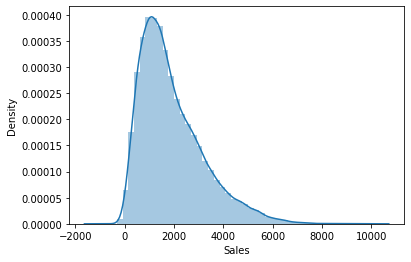

In [ ]:
sns.distplot(train['Sales']);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


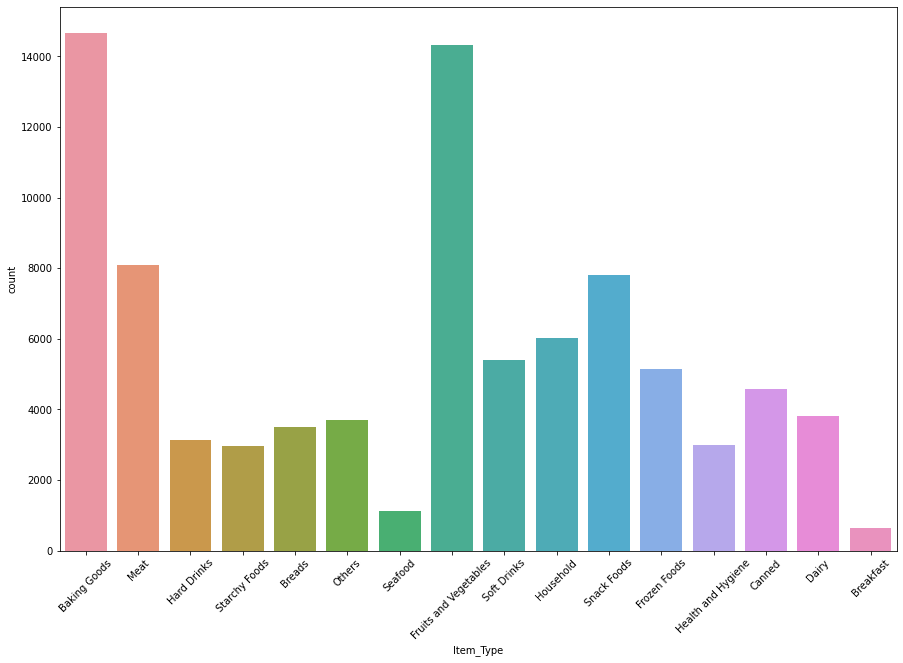

In [ ]:
plt.figure(figsize=(15,10))
count = sns.countplot(train['Item_Type'])
count.set_xticklabels(count.get_xticklabels(),rotation = 45);

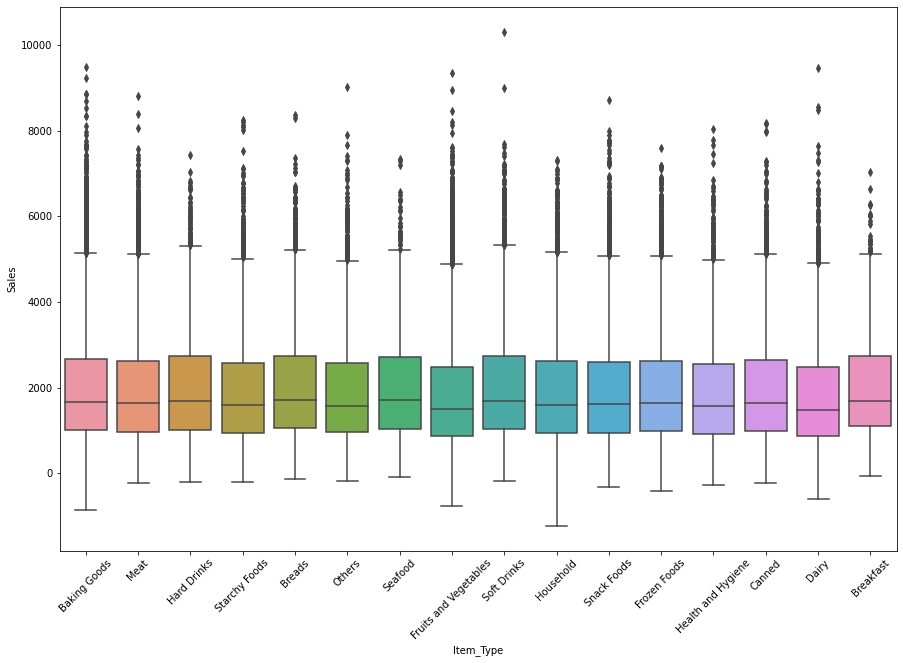

In [ ]:
plt.figure(figsize=(15,10))
box = sns.boxplot(x = train['Item_Type'], y = train['Sales']);
box.set_xticklabels(box.get_xticklabels(),rotation = 45);

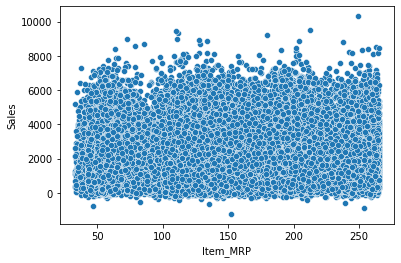

In [ ]:
sns.scatterplot(x = train['Item_MRP'],y = train['Sales']);

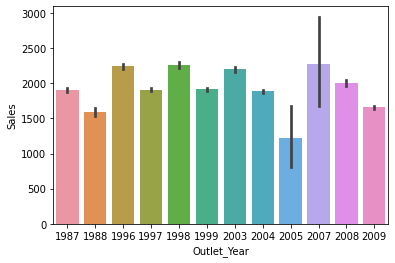

In [ ]:
sns.barplot(x = train['Outlet_Year'], y =train['Sales']);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


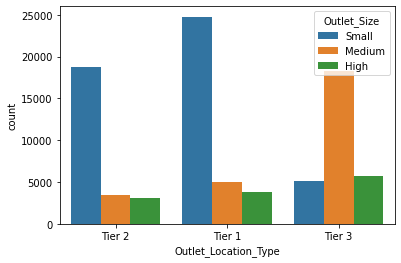

In [ ]:
sns.countplot(train['Outlet_Location_Type'],hue = train['Outlet_Size']);

# Data Preprocessing

**Outliers**

In [ ]:
train['Sales'].describe()

count    87864.000000
mean      1911.842120
std       1291.386004
min      -1229.360345
25%        959.249675
50%       1606.307877
75%       2608.057736
max      10309.283310
Name: Sales, dtype: float64

In [ ]:
#Finding Outliers using interquartile range
iqr = 2608.057736 - 959.249675 #third quartile - first quartile (Q3 - Q1)
ub = 1.5 * iqr #upper bound
lb = -1.5 * iqr #lower bound

In [ ]:
out = train[(train['Sales']<lb) | (train['Sales']>ub)] 
out

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,3437.350375
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,3129.967268
13,FDG32,21.106734,Baking Goods,129.801533,OUT046,1997,Small,Tier 3,6379.790499
17,FDP40,20.887657,Baking Goods,115.760555,OUT035,1996,Small,Tier 1,3079.652222
...,...,...,...,...,...,...,...,...,...
87856,FDG33,18.609816,Snack Foods,165.785800,OUT035,1997,High,Tier 1,4091.864332
87858,FDB15,10.895000,Dairy,264.356800,OUT018,2009,Medium,Tier 3,4745.822400
87859,FDG24,9.994412,Breakfast,147.389893,OUT035,1987,Medium,Tier 3,4975.646052
87861,FDM04,11.385812,Household,119.028901,OUT018,1997,Medium,Tier 1,2716.058050


Total outleirs -> 24241

No Linear Collinearity between the two.

**Data Preprocessing**

In [ ]:
cat_l = []
num_l = []
for i in train.columns:
  if(train[i].dtype=='object'):
    cat_l.append(i)
  else:
    num_l.append(i)

In [ ]:
cat_l

['Item_ID', 'Item_Type', 'Outlet_ID', 'Outlet_Size', 'Outlet_Location_Type']

In [ ]:
num_l

['Item_W', 'Item_MRP', 'Outlet_Year', 'Sales']

**Categorical Encoding** -
1. Item_type, Outlet_id, Outlet_year - One Hot Encoding
2. Outlet_Size, Outlet_location_type - Ordinal Encoding


In [ ]:
one_hot_l = ['Item_Type','Outlet_Year','Outlet_ID']

In [ ]:
###Train- One hot encoding#####
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
dummy_df = pd.DataFrame(encoder.fit_transform((train[one_hot_l])))
dummy_df.index = train.index
dummy_df.columns = encoder.get_feature_names(one_hot_l)

In [ ]:
train.drop(one_hot_l,axis=1,inplace = True)
train = pd.concat([train,dummy_df],axis=1)

In [ ]:
###Test - One Hot Encoding#####
dummy_df = pd.DataFrame(encoder.transform((test[one_hot_l])))
dummy_df.index = test.index
dummy_df.columns = encoder.get_feature_names(one_hot_l)

In [ ]:
test.drop(one_hot_l,axis=1,inplace = True)
test = pd.concat([test,dummy_df],axis=1)

In [ ]:
print(train.shape)
print(test.shape)

(87864, 39)
(37656, 38)


In [ ]:
train['Outlet_Size'].value_counts()

Small     48614
Medium    26683
High      12567
Name: Outlet_Size, dtype: int64

In [ ]:
test['Outlet_Size'].value_counts()

Medium    15236
Small     13504
High       8916
Name: Outlet_Size, dtype: int64

In [ ]:
train['Outlet_Location_Type'].value_counts()

Tier 1    33567
Tier 3    29044
Tier 2    25253
Name: Outlet_Location_Type, dtype: int64

In [ ]:
test['Outlet_Location_Type'].value_counts()

Tier 3    15732
Tier 1    12830
Tier 2     9094
Name: Outlet_Location_Type, dtype: int64

In [ ]:
### Train Ordinal Encoding ###
size_d = {'Small' : 0,'Medium' : 1, 'High' : 2} #High > Medium > Small
tier_d = {'Tier 3' : 0, 'Tier 2' : 1, 'Tier 1' : 2} #Tier 1 > Tier 2 > Tier 3

train['Outlet_Size'] = train['Outlet_Size'].map(size_d)
train['Outlet_Location_Type'] = train['Outlet_Location_Type'].map(tier_d)


In [ ]:
## Test ordinal Encoding
test['Outlet_Size'] = test['Outlet_Size'].map(size_d)
test['Outlet_Location_Type'] = test['Outlet_Location_Type'].map(tier_d)


**Feature Engineering**

In [ ]:
train['Item_ID'].nunique()

895

Also an individual product maybe cosutmer favourite. So we use item_id feature.

**Item ID Type**

In [ ]:

train['item_id_type'] = train['Item_ID'].apply(lambda x : str(x[0:3]))
test['item_id_type'] = test['Item_ID'].apply(lambda x : str(x[0:3]))


In [ ]:
#ordinal encoding of item_id_type on Item_MRP
ordinal_labels=train.groupby(['item_id_type'])['Item_MRP'].mean().sort_values().index
ordinal_labels2={k:i for i,k in enumerate(ordinal_labels,0)}

In [ ]:
#train
train['item_id_type'] = train['item_id_type'].map(ordinal_labels2)
#test
test['item_id_type'] = test['item_id_type'].map(ordinal_labels2)

In [ ]:
train.drop('Item_ID',axis=1,inplace=True)
test.drop('Item_ID',axis=1,inplace=True)

**Years from the present**

In [ ]:
temp1 = pd.read_csv('/content/train.csv')
temp2 = pd.read_csv('/content/test.csv')
train['Years_from_present'] = temp1['Outlet_Year'].apply(lambda x: 2021 - x)
test['Years_from_present'] = temp2['Outlet_Year'].apply(lambda x: 2021 - x)

# Modeling

In [ ]:
X = train.drop('Sales',axis=1)
y = train['Sales']

In [ ]:
def rmse(X,y):
  return np.sqrt(mean_squared_error(X,y))

In [ ]:
X.columns

Index(['Item_W', 'Item_MRP', 'Outlet_Size', 'Outlet_Location_Type',
       'Item_Type_Baking Goods', 'Item_Type_Breads', 'Item_Type_Breakfast',
       'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods', 'Outlet_Year_1987',
       'Outlet_Year_1988', 'Outlet_Year_1996', 'Outlet_Year_1997',
       'Outlet_Year_1998', 'Outlet_Year_1999', 'Outlet_Year_2003',
       'Outlet_Year_2004', 'Outlet_Year_2005', 'Outlet_Year_2007',
       'Outlet_Year_2008', 'Outlet_Year_2009', 'Outlet_ID_OUT013',
       'Outlet_ID_OUT018', 'Outlet_ID_OUT035', 'Outlet_ID_OUT046',
       'Outlet_ID_OUT049', 'item_id_type', 'Years_from_present'],
      dtype='object')

In [ ]:
xgr = XGBRegressor()
las = Lasso()
rid = Ridge()
lgbm = LGBMRegressor()

In [ ]:
#Evaluating each alogirthm on the metric - RMSE
for i in [las,rid,lgbm,xgr]:
  print(cross_val_score(i,X,y,cv = 3,scoring = make_scorer(rmse)).mean())

1275.889358092017
1275.9695880611491
1279.2123090336643
[05:11:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:12:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:12:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1275.7252379570666


**Feature Importance**

[05:13:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


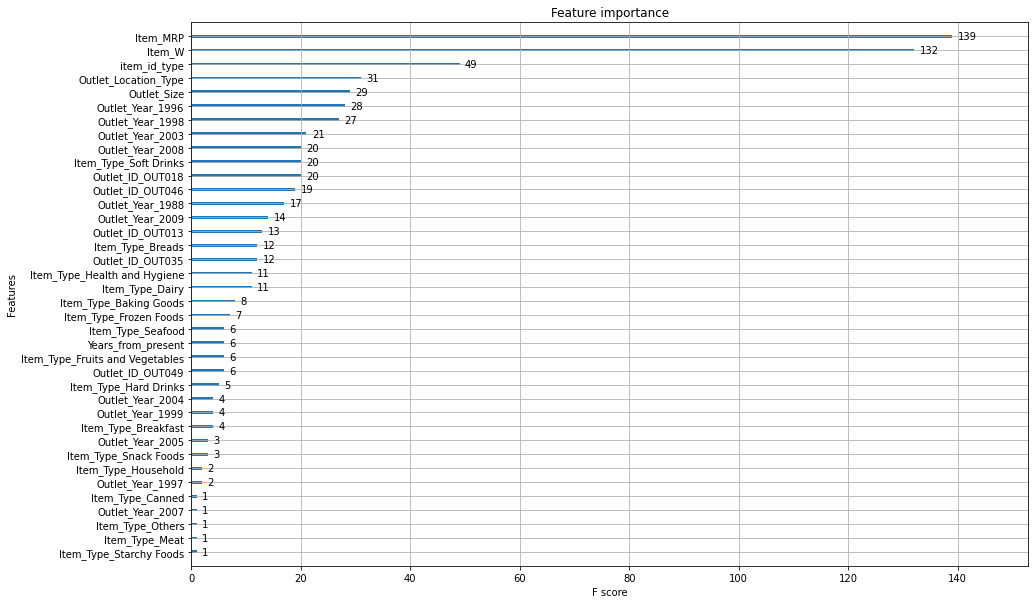

In [ ]:
#feature importance xgboost
from xgboost import plot_importance
xgb = XGBRegressor()
xgb.fit(X,y)
fig, ax = plt.subplots(figsize=(15, 10))
plot_importance(xgb, ax=ax)

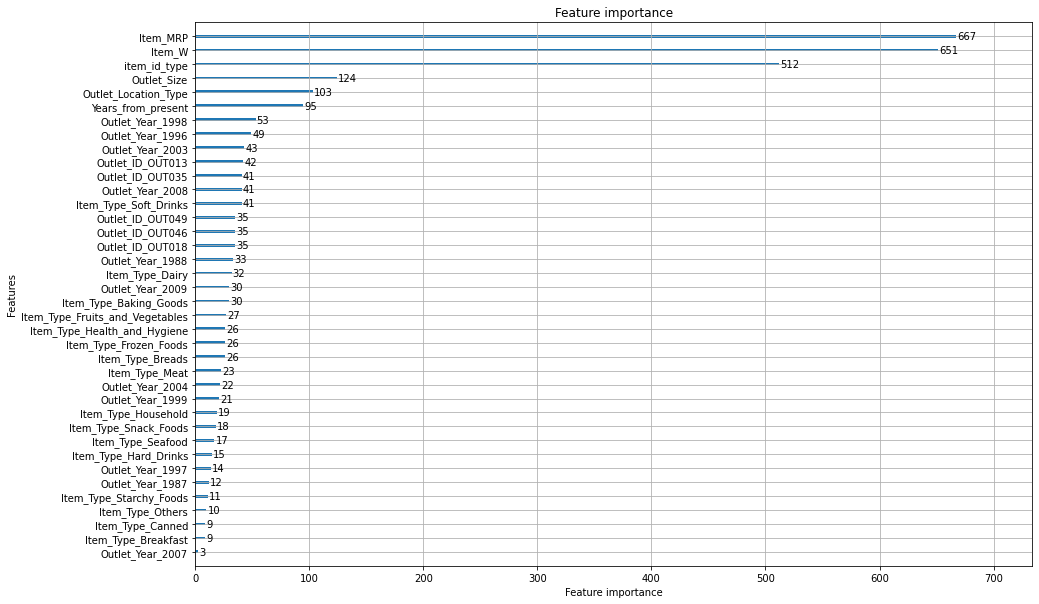

In [ ]:
from lightgbm import plot_importance
lgbm = LGBMRegressor()
lgbm.fit(X,y)
fig, ax = plt.subplots(figsize=(15, 10))
plot_importance(lgbm, ax=ax)

# Weighted Average Ensemble

In [ ]:
xgr = XGBRegressor()
las = Lasso()
rid = Ridge()
lgbm = LGBMRegressor()
models = [('las',las),('lgbm',lgbm),('xgr',xgr),('rid',rid)]

In [ ]:
### Train - Validation Split ###
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
def evaluate_models(models, X_train, X_val, y_train, y_val):
	# fit and evaluate the models
	scores = list()
	for name, model in models:
		# fit the model
		model.fit(X_train, y_train)
		# evaluate the model
		yhat = model.predict(X_val)
		error = rmse(y_val, yhat)
		# store the performance
		scores.append(-error) #Lower the error, higher the weight
		# report model performance
	return scores

In [ ]:
# fit and evaluate each model
scores = evaluate_models(models,X_train, X_val, y_train, y_val)
print(scores)
# create the ensemble
ensemble = VotingRegressor(estimators=models, weights=scores) # giving the repective weights

[05:15:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[-1277.8720297956588, -1277.776201028559, -1276.6774218494174, -1277.7158253834132]


In [ ]:
print(cross_val_score(ensemble,X,y,cv = 3,scoring = make_scorer(rmse)).mean())

[05:15:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:16:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:16:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1275.060856641124


In [ ]:
# fit the ensemble on the training dataset
ensemble.fit(X, y)

[09:35:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


VotingRegressor(estimators=[('las',
                             Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                                   max_iter=1000, normalize=False,
                                   positive=False, precompute=False,
                                   random_state=None, selection='cyclic',
                                   tol=0.0001, warm_start=False)),
                            ('lgbm',
                             LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           mi...
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=0,
                                          reg_lam

In [ ]:
sub_df = pd.DataFrame()
ans = ensemble.predict(test)
sub_df['Sales'] = ans

Submission

In [ ]:
sub_df.to_csv('submission.csv',index = False)
sub_df

,Sales
0,2056.868467
1,1859.601913
2,1794.128027
3,1757.407581
4,1536.313639
...,...
37651,1438.095382
37652,1458.826777
37653,1815.988324
37654,1441.286614
